Bibliotecas

In [1]:
import numpy as np
import jax 
import jax.numpy as jnp
import networkx as nx

Primer Arbol - Especificacion de la estructura del grafo

In [2]:
class abstract_graph:
    #estructura del grafo , estructura edges y nodes
    def __init__(self,_edges):
        self.edges=_edges
        self.nodes={u for u,v in self.edges} | {v for u,v in self.edges}
    
    # no se utiliza
    def adjacency_matrix(self):
        pass
    
    def adjacency_list(self):
        pass

    
class simple_graph(abstract_graph):
    #hereda clase abstract_graph
    # establece que el grafo no contengan aristas repetidas y crea todos los nodos
    def __init__(self,_edges):
        tmp=[]
        for (u,v) in _edges: 
            #recorre todos los nodos (u,v) en la lista de arista _edges y las agrega a tmp[]
            tmp.append((u,v))
            # si la  otra arista del par se encuentra en tmp[] y los pares son diferente -> se agregan a tmp
            if (v,u) not in tmp and v!=u:
                tmp.append((v,u))
        #se asignan todas las aristas de tmp[]
        self.edges=tmp
        #crea conjuntos {} -> se combinan los nodos con el origen(u) y destino(v)
        #en self.nodes se almacenan todos los nodos
        self.nodes={u for u,v in _edges} | {v for u,v in _edges}
     
    def adjacency_matrix(self):
        # crea matriz adyacente 
        n=len(self.nodes)
        mat=jnp.zeros((n,n))
        for i,v in enumerate(self.nodes):
            for j,k in enumerate(self.nodes):
                if (v,k) in self.edges:
                    mat.at[i,j].set(1)
        return mat
    
    
    def adjacency_list(self):
        adjacent=lambda n : {v for u,v in self.edges if u==n } 
        return {v:adjacent(v) for v in self.nodes}

  
class weighted_graph(simple_graph):
    
    def __init__(self,_edges):
        tmp=dict()
        for (u,v),w in _edges.items():
            tmp.update({(u,v):w})
            if (v,u) not in tmp.keys() and v!=u:
                tmp.update({(v,u):w})
        self.edges=tmp
        self.nodes={u for u,v in _edges} | {v for u,v in _edges}

Algoritmo Kruskal con JAX

In [3]:
def naive_find(C, u):
    # input -> C :  conjuntos , u :  nodo
    # busqueda en el los conjuntos C , donde pertenece el nodo u
    while C.at[u].get() != u:
        # verifica si el nodo u es la raiz de el conjunto C
        u = C.at[u].get().item()
        # actualiza valor de u con su valor padre (raiz) 
        # item(): valor entero del padre
        # get(): valor
        # .at(): para obtener elemento del conjunto
    return u
    # output -> valor de la raiz

def naive_union(C, u, v):
    # input -> C : conjunto , u : nodo para unir , v: nodo para unir
    # une conjuntos de los nodos u y v , encontrando las raises de los conjuntos
    u = naive_find(C, u)
    v = naive_find(C, v)
    # identifica raices del conjunto
    return C.at[u].set(v)
    # output ->  el valor C , asociado al conjunto U, del nodo u

        
def jax_kruskal(G):
    # input -> G : grafo con atributo 'edges' y 'nodes' 
    # 
    E = G.edges
    T=[]
    # T[] lista donde guardara el arbol de expansion minima
    values=jnp.array([*E.values()])
    items=[*E.keys()]
    # guarda los values: valores y keys: nodos en dos variables
    C= jnp.arange(len(G.nodes))
    # arrego de JAX de conjuntos / arange: obtener todos los nodos de 0 hasta len(G.nodes)-1
    i_sort=jnp.argsort(values)
    # hace un ordenamiento de aristas ascendente / variable np.argsort (X5 velocidad)
    for ix in i_sort:
        # recorre aristas ordenadas
        (u,v),weight=items[ix.item()],values[ix.item()].item()

        if naive_find(C, u) != naive_find(C, v): 
            # condicion de que ambos nodos son de diferente conjunto / evita ciclos
            T.append((u,v,{'weight':weight}))
            # agrega arista formato : tupla y peso
            naive_union(C, u, v)
            # une conjuntos
    return T
    # output ->  el arbol de expancion minima , en una lista de tuplas 
    # '(u , v,{'weight' : weight})' / u , v : nodos / weigh : peso de la union 

Algoritmo Prim en JAX

In [4]:
def jax_prim(graph,start):
    nodes=list(G1.nodes)
    parents={n:None for n in nodes}
    tree=[]
    frontier=jnp.array([jnp.inf]*len(nodes))
    pos=nodes.index(start)
    frontier=frontier.at[pos].set(0.0)
    adjacency=graph.adjacency_list()
    visited=set()
    for _ in range(len(nodes)+1):
        pos=jnp.argmin(frontier).item()
        weight=frontier.at[pos].get().item()
        v=nodes[pos]
        if v in visited:
            continue
        visited.update({v})
        frontier=frontier.at[pos].set(jnp.inf)
        u=parents[v]
        tree.append((u,v,{'weight':weight}))
        for neighbor in adjacency[v]:
            if neighbor not in visited:
                n_pos=nodes.index(neighbor)
                n_weight=frontier.at[n_pos].get().item()
                if graph.edges[(v,neighbor)]<n_weight:
                  parents[neighbor]=v
                  frontier=frontier.at[n_pos].set(graph.edges[(v,neighbor)])
    return tree

Primer Grafo de los datos CSV

In [5]:
import csv
import time

# Diccionario para almacenar los datos
E1 = {}

# Lectura del archivo CSV
with open("GD00_c.csv", 'r') as file:
    reader = csv.reader(file)
    for row in reader:
        # Obtener los valores del CSV
        values = list(map(int, row))
        
        # Crear las aristas y pesos
        for i in range(len(values) - 1):
            u = values[i]
            v = values[i + 1]
            weight = abs(v - u)  # Puedes asignar cualquier peso deseado
            
            # Agregar la arista y peso al diccionario
            E1[(u, v)] = weight

# Crear el objeto de grafo ponderado
G1 = weighted_graph(E1)



Ejecucion de algoritmos en primer arbol

In [6]:
# Ejecutar el algoritmo de Kruskal
t1=time.time()
T_jax_kruskal=jax_kruskal(G1)
t2=time.time()
print('Algoritmo Kruskal JAX Tiempo : {0:2f}[s], Peso : {1}'.format(t2-t1,sum([k['weight'] for (u,v,k) in T_jax_kruskal])))



Algoritmo Kruskal JAX Tiempo : 18.119950[s], Peso : 473940


In [7]:

#Ejecutar el algoritmo de Prim
t3=time.time()
T_jax_prim=jax_prim(G1,1)
t4=time.time()
print('Algoritmo Prim JAX Tiempo : {0:2f}[s], Peso : {1}'.format(t4-t3,sum([k['weight'] for (u,v,k) in T_jax_prim])))

Algoritmo Prim JAX Tiempo : 7.539879[s], Peso : 38979.0


Grafica del primer arbol

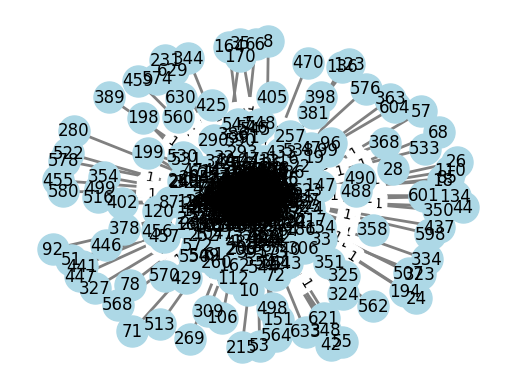

In [8]:
import networkx as nx
import matplotlib.pyplot as plt

# Crear un objeto de grafo no dirigido
G1_tree = nx.Graph()

# Agregar las aristas al grafo
for u, v in G1.edges:
    G1_tree.add_edge(u, v, weight=G1.edges[(u, v)])

# Dibujar el árbol
pos = nx.spring_layout(G1_tree)
edge_labels = nx.get_edge_attributes(G1_tree, 'weight')

# Dibujar los nodos
nx.draw_networkx_nodes(G1_tree, pos, node_color='lightblue', node_size=500)

# Dibujar las aristas
nx.draw_networkx_edges(G1_tree, pos, edge_color='gray', width=2)

# Dibujar las etiquetas de peso en las aristas
nx.draw_networkx_edge_labels(G1_tree, pos, edge_labels=edge_labels, font_color='black')

# Dibujar las etiquetas de nodo
nx.draw_networkx_labels(G1_tree, pos, font_color='black')

# Mostrar el gráfico
plt.axis('off')
plt.show()

Segundo Arbol - Especificacion de la estructura del grafo

In [9]:

class abstract_graph:

    def __init__(self,_edges):
        self.edges=_edges
        self.nodes={x for x,y in self.edges} | {y for x,y in self.edges}

    def adjacency_matrix(self):
        pass

    def adjacency_list(self):
        pass


class simple_graph(abstract_graph):

    def __init__(self,_edges):
        tmp=[]
        for (x,y) in _edges:
            tmp.append((x,y))
            if (y,x) not in tmp and y!=x:
                tmp.append((y,x))
        self.edges=tmp
        self.nodes={x for x,y in _edges} | {y for x,y in _edges}

    def adjacency_matrix(self):
        # completar
        n=len(self.nodes)
        mat=jnp.zeros((n,n))
        for i,y in enumerate(self.nodes):
            for j,k in enumerate(self.nodes):
                if (y,k) in self.edges:
                    mat.at[i,j].set(1)
        return mat


    def adjacency_list(self):
        adjacent=lambda n : {y for x,y in self.edges if x==n }
        return {x:adjacent(x) for x in self.nodes}


class weighted_graph(simple_graph):

    def __init__(self,_edges):
        tmp=dict()
        for (x,y),w in _edges.items():
            tmp.update({(x,y):w})
            if (y,x) not in tmp.keys() and y!=x:
                tmp.update({(y,x):w})
        self.edges=tmp
        self.nodes={x for x,y in _edges} | {y for x,y in _edges}

Algoritmo Kruskal con JAX

In [10]:


def naive_find(C, x):
    while C.at[x].get() != x:
        x = C.at[x].get().item()
    return x

def naive_union(C, x, y):
    x = naive_find(C, x)
    y = naive_find(C, y)
    return C.at[x].set(y)

def jax_kruskal(G):
    E = G.edges
    T=[]
    values=jnp.array([*E.values()])
    items=[*E.keys()]
    C= jnp.arange(len(G.nodes))
    i_sort=jnp.argsort(values)
    for ix in i_sort:
        (x,y),weight=items[ix.item()],values[ix.item()].item()
        if naive_find(C, x) != naive_find(C, y):
            T.append((x,y,{'weight':weight}))
            naive_union(C, x, y)
    return T

Algoritmo Prim en JAX

In [11]:


def jax_prim(graph,start):
    nodes=list(G2.nodes)
    parents={n:None for n in nodes}
    tree=[]
    frontier=jnp.array([jnp.inf]*len(nodes))
    pos=nodes.index(start)
    frontier=frontier.at[pos].set(0.0)
    adjacency=graph.adjacency_list()
    visited=set()
    for _ in range(len(nodes)+1):
        pos=jnp.argmin(frontier).item()
        weight=frontier.at[pos].get().item()
        y=nodes[pos]
        if y in visited:
            continue
        visited.update({y})
        frontier=frontier.at[pos].set(jnp.inf)
        x=parents[y]
        tree.append((x,y,{'weight':weight}))
        for neighbor in adjacency[y]:
            if neighbor not in visited:
                n_pos=nodes.index(neighbor)
                n_weight=frontier.at[n_pos].get().item()
                if graph.edges[(y,neighbor)]<n_weight:
                  parents[neighbor]=y
                  frontier=frontier.at[n_pos].set(graph.edges[(y,neighbor)])
    return tree

Segundo Arbol de los datos CSV

In [12]:
"""Meter segundos datos CSV"""

import csv
import time
print("weight", weight)

# Diccionario para almacenar los datos
E2 = {}

# Lectura del archivo CSV
with open("Cities.csv", 'r') as file:
    reader = csv.reader(file)
    for row in reader:
        # Obtener los valores del CSV
        values = list(map(int, row))

        # Crear las aristas y pesos
        for i in range(len(values) - 1):
            x = values[i]
            y = values[i + 1]
            weight = abs(y - x)  # Puedes asignar cualquier peso deseado

            # Agregar la arista y peso al diccionario
            E2[(x, y)] = weight

# Crear el objeto de grafo ponderado
G2 = weighted_graph(E2)


weight 634


Ejecucion de los algoritmos en el segundo arbol

In [13]:
# Ejecutar el algoritmo de Kruskal
t5=time.time()
T_jax_kruskal=jax_kruskal(G2)
t6=time.time()
print('Algoritmo Kruskal JAX Tiempo : {0:2f}[s], Peso : {1}'.format(t6-t5,sum([k['weight'] for (u,v,k) in T_jax_kruskal])))


Algoritmo Kruskal JAX Tiempo : 14.648756[s], Peso : 44356


In [14]:

#Ejecutar el algoritmo de Prim
t7=time.time()
T_jax_prim2=jax_prim(G2,1)
t8=time.time()
print('Algoritmo Prim JAX Tiempo : {0:2f}[s], Peso : {1}'.format(t8-t7,sum([k['weight'] for (u,v,k) in T_jax_prim2])))

Algoritmo Prim JAX Tiempo : 5.360262[s], Peso : 1451.0


Grafica del segundo arbol

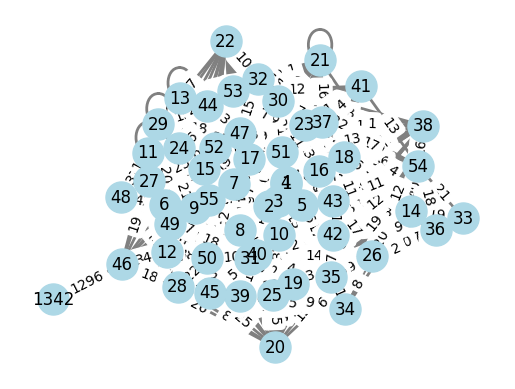

In [15]:
import networkx as nx
import matplotlib.pyplot as plt

# Crear un objeto de grafo no dirigido
G2_tree = nx.Graph()

# Agregar las aristas al grafo
for x, y in G2.edges:
    G2_tree.add_edge(x, y, weight=G2.edges[(x, y)])

# Dibujar el árbol
pos = nx.spring_layout(G2_tree)
edge_labels = nx.get_edge_attributes(G2_tree, 'weight')

# Dibujar los nodos
nx.draw_networkx_nodes(G2_tree, pos, node_color='lightblue', node_size=500)

# Dibujar las aristas
nx.draw_networkx_edges(G2_tree, pos, edge_color='gray', width=2)

# Dibujar las etiquetas de peso en las aristas
nx.draw_networkx_edge_labels(G2_tree, pos, edge_labels=edge_labels, font_color='black')

# Dibujar las etiquetas de nodo
nx.draw_networkx_labels(G2_tree, pos, font_color='black')

# Mostrar el gráfico
plt.axis('off')
plt.show()

Tercer Arbol - Especificacion de la estructura del grafo

In [16]:
class abstract_graph:
    
    def __init__(self,_edges):
        self.edges=_edges
        self.nodes={a for a,b in self.edges} | {b for a,b in self.edges}
        
    def adjacency_matrix(self):
        pass
    
    def adjacency_list(self):
        pass

    
class simple_graph(abstract_graph):
    
    def __init__(self,_edges):
        tmp=[]
        for (a,b) in _edges:
            tmp.append((a,b))
            if (b,a) not in tmp and b!=a:
                tmp.append((b,a))
        self.edges=tmp
        self.nodes={a for a,b in _edges} | {b for a,b in _edges}
     
    def adjacency_matrix(self):
        # completar
        n=len(self.nodes)
        mat=jnp.zeros((n,n))
        for i,v in enumerate(self.nodes):
            for j,k in enumerate(self.nodes):
                if (v,k) in self.edges:
                    mat.at[i,j].set(1)
        return mat
    
    
    def adjacency_list(self):
        adjacent=lambda n : {b for a,b in self.edges if a==n } 
        return {a:adjacent(a) for a in self.nodes}

  
class weighted_graph(simple_graph):
    
    def __init__(self,_edges):
        tmp=dict()
        for (a,b),w in _edges.items():
            tmp.update({(a,b):w})
            if (b,a) not in tmp.keys() and b!=a:
                tmp.update({(b,a):w})
        self.edges=tmp
        self.nodes={a for a,b in _edges} | {b for a,b in _edges}

Algoritmo Kruskal con JAX

In [17]:


def naive_find(C, a):
    while C.at[a].get() != a:
        a = C.at[a].get().item()
    return a

def naive_union(C, a, b):
    a = naive_find(C, a)
    b = naive_find(C, b)
    return C.at[a].set(b)
        
def jax_kruskal(G):
    E = G.edges
    T=[]
    values=jnp.array([*E.values()])
    items=[*E.keys()]
    C= jnp.arange(len(G.nodes))
    i_sort=jnp.argsort(values)
    for ix in i_sort:
        (a,b),weight=items[ix.item()],values[ix.item()].item()
        if naive_find(C, a) != naive_find(C, b): 
            T.append((a,b,{'weight':weight}))
            naive_union(C, a, b)
    return T

Algoritmo Prim en JAX

In [18]:


def jax_prim(graph,start):
    nodes=list(G3.nodes)
    parents={n:None for n in nodes}
    tree=[]
    frontier=jnp.array([jnp.inf]*len(nodes))
    pos=nodes.index(start)
    frontier=frontier.at[pos].set(0.0)
    adjacency=graph.adjacency_list()
    visited=set()
    for _ in range(len(nodes)+1):
        pos=jnp.argmin(frontier).item()
        weight=frontier.at[pos].get().item()
        b=nodes[pos]
        if b in visited:
            continue
        visited.update({b})
        frontier=frontier.at[pos].set(jnp.inf)
        a=parents[b]
        tree.append((a,b,{'weight':weight}))
        for neighbor in adjacency[b]:
            if neighbor not in visited:
                n_pos=nodes.index(neighbor)
                n_weight=frontier.at[n_pos].get().item()
                if graph.edges[(b,neighbor)]<n_weight:
                  parents[neighbor]=b
                  frontier=frontier.at[n_pos].set(graph.edges[(b,neighbor)])
    return tree


Tercer Arbol de los datos CSV

In [19]:


import csv
import time
print("weigt", weight)

# Diccionario para almacenar los datos
E3 = {}

# Lectura del archivo CSV
with open("CAG_mat72.csv", 'r') as file:
    reader = csv.reader(file)
    for row in reader:
        # Obtener los valores del CSV
        values = list(map(int, row))
        
        # Crear las aristas y pesos
        for i in range(len(values) - 1):
            a = values[i]
            b = values[i + 1]
            weight = abs(b - a)  # Puedes asignar cualquier peso deseado
            
            # Agregar la arista y peso al diccionario
            E3[(a, b)] = weight

# Crear el objeto de grafo ponderado
G3 = weighted_graph(E3)


weigt 45


Ejecucion de los algoritmos en el tercer grafo

In [20]:
# Ejecutar el algoritmo de Kruskal
t9=time.time()
T_jax_kruskal=jax_kruskal(G3)
t10=time.time()
print('Algoritmo Kruskal JAX Tiempo : {0:2f}[s], Peso : {1}'.format(t10-t9,sum([k['weight'] for (a,b,k) in T_jax_kruskal])))

Algoritmo Kruskal JAX Tiempo : 13.256894[s], Peso : 34436


In [21]:
#Ejecutar el algoritmo de Prim
t11=time.time()
T_jax_prim=jax_prim(G3,1)
t12=time.time()
print('Algoritmo Prim JAX Tiempo : {0:2f}[s], Peso : {1}'.format(t12-t11,sum([k['weight'] for (a,b,k) in T_jax_prim])))

Algoritmo Prim JAX Tiempo : 4.049730[s], Peso : 1126.0


Grafica del tercer grafo

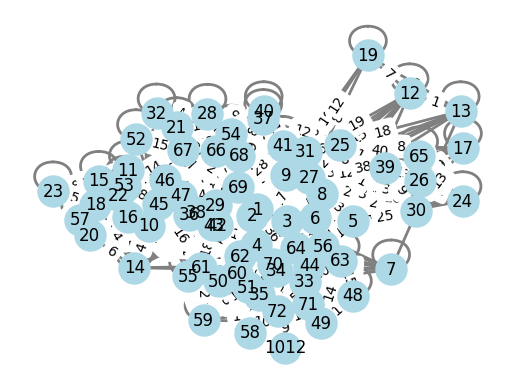

In [22]:
import networkx as nx
import matplotlib.pyplot as plt

# Crear un objeto de grafo no dirigido
G3_tree = nx.Graph()

# Agregar las aristas al grafo
for a, b in G3.edges:
    G3_tree.add_edge(a, b, weight=G3.edges[(a, b)])

# Dibujar el árbol
pos = nx.spring_layout(G3_tree)
edge_labels = nx.get_edge_attributes(G3_tree, 'weight')

# Dibujar los nodos
nx.draw_networkx_nodes(G3_tree, pos, node_color='lightblue', node_size=500)

# Dibujar las aristas
nx.draw_networkx_edges(G3_tree, pos, edge_color='gray', width=2)

# Dibujar las etiquetas de peso en las aristas
nx.draw_networkx_edge_labels(G3_tree, pos, edge_labels=edge_labels, font_color='black')

# Dibujar las etiquetas de nodo
nx.draw_networkx_labels(G3_tree, pos, font_color='black')

# Mostrar el gráfico
plt.axis('off')
plt.show()
